# Rank selection metrics

This notebook computes the metrics we used for rank selection, including:
- cophenetic correlation coefficients ([Brunet et al. 2013](https://www.pnas.org/content/101/12/4164), [Frigyesi and Höglund 2008](https://journals.sagepub.com/doi/10.4137/CIN.S606))
- mean squared error ([Frigyesi and Höglund 2008](https://journals.sagepub.com/doi/10.4137/CIN.S606), [Hutchins et al. 2008](https://academic.oup.com/bioinformatics/article/24/23/2684/180798))

We will first figure out the pre-calculated tsNMF runs to include, and then compute the cophenetic correlation coefficients and MSE as a function of rank. 

In [1]:
import os
import glob
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr
import dill

## Load MVBS data

In [2]:
MVBS_PCP_path = '../data/'
MVBS_rpca_file = '20150817-20151017_MVBS_time_Sv_rangeBin5_all_corrected_rpca.nc'

MVBS_rpca = xr.open_dataset(os.path.join(MVBS_PCP_path, MVBS_rpca_file))
low_rank = MVBS_rpca['low_rank']
n_observations, n_frequencies, n_depth_levels, n_pings = low_rank.shape

In [3]:
low_rank = low_rank.values.reshape([n_observations,-1])

In [4]:
low_rank_nonneg = low_rank - low_rank.min()
low_rank_nonneg.shape

(62, 15984)

## Load shuffled data

In [5]:
with open('../data/low_rank_MVBS_data_shuffled_axday.pkl', 'rb') as ff:
    data_shuffle_axday = dill.load(ff)

## Get all filenames

### Get rank=1 fname

In [6]:
original_r1_path = '../data/precalc_tsnmf/smoothness_sweep_dict/sm5e5_sp0_rank1only/'
shuffled_r1_path = '../data/precalc_tsnmf/shuffled_dict/sm5e5_sp0_rank1only/'
original_r1_fname = sorted(glob.glob(os.path.join(original_r1_path, '*.pkl')))
shuffled_r1_fname = sorted(glob.glob(os.path.join(shuffled_r1_path, '*.pkl')))

### Get rank=2-8 fname

In [7]:
original_path = '../data/precalc_tsnmf/smoothness_sweep_dict/sm5e5_sp0/'
shuffled_path = '../data/precalc_tsnmf/shuffled_dict/sm5e5_sp0/'
original_fname = sorted(glob.glob(os.path.join(original_path, '*.pkl')))
shuffled_fname = sorted(glob.glob(os.path.join(shuffled_path, '*.pkl')))

### Combine all fname

In [8]:
original_fname = original_r1_fname + original_fname
shuffled_fname = shuffled_r1_fname + shuffled_fname

In [9]:
rank_all = np.arange(1,10)

## MSE and smoothness regularization cost (SMC)

### Functions to calculate mse and sparisty cost

In [10]:
def calc_mse(output_holder, fname_list, data):
    """
    Calculate MSE for each model.

    Parameters
    ----------
    output_holder
        list to hold all MSE
    fname_list
        list of filename containing ssNMF results
    data
        data before decomposition
        `data = low_rank_nonneg.T` for the original data.    
        `data = data_shuffle_axday` for the shuffled data.
    """
    for ff in fname_list:
        with open(ff,'rb') as openfile:
            x = dill.load(openfile)
        mse = []
        for mm in x:
            mse.append(np.linalg.norm(data - mm['W']@mm['H'])**2/low_rank_nonneg.size)
        output_holder += mse
    return output_holder

In [11]:
def calc_smc(output_holder, fname_list):
    """
    Calculate sparsity reg cost from each model.
    
    Parameters
    ----------
    output_holder
        list to hold all MSE
    fname_list
        list of filename containing ssNMF results
    """
    for ff in fname_list:
        with open(ff,'rb') as openfile:
            x = dill.load(openfile)
        smc = []
        for mm in x:
            smc.append(np.linalg.norm(mm['H'][:,1:] - mm['H'][:,:-1])**2)
        output_holder += smc
    return output_holder

### Compute MSE and smoothness regularization cost (SMC)

In [12]:
# Original data
mse_ori = calc_mse([], original_fname, data=low_rank_nonneg.T)
smc_ori = calc_smc([], original_fname)

In [13]:
# Shuffled data
mse_shf = calc_mse([], shuffled_fname, data=data_shuffle_axday)
smc_shf = calc_smc([], shuffled_fname)

In [14]:
# Sanity check: dimension should all be 320*9
len(mse_ori), len(smc_ori), len(mse_shf), len(smc_shf)

(2880, 2880, 2880, 2880)

Reshape these results for the next step:

In [15]:
mse_ori = np.array(mse_ori).reshape((len(rank_all),-1))
smc_ori = np.array(smc_ori).reshape((len(rank_all),-1))
mse_shf = np.array(mse_shf).reshape((len(rank_all),-1))
smc_shf = np.array(smc_shf).reshape((len(rank_all),-1))

In [16]:
# Sanity check: should be 9x320 = number of rank x number of runs per rank
mse_ori.shape

(9, 320)

## k-means clustering to separate outliers

From the notebook `cophcorr_coeff/cophcorr_change_runs_included_weighting.ipynb` we know that that we want to separate out the 2 significant outliers for the rank=2 and rank=3 results, but keep all other runs when calculate metrics for rank selection. Let's find these 2 outliers again below:

In [17]:
from sklearn.cluster import KMeans

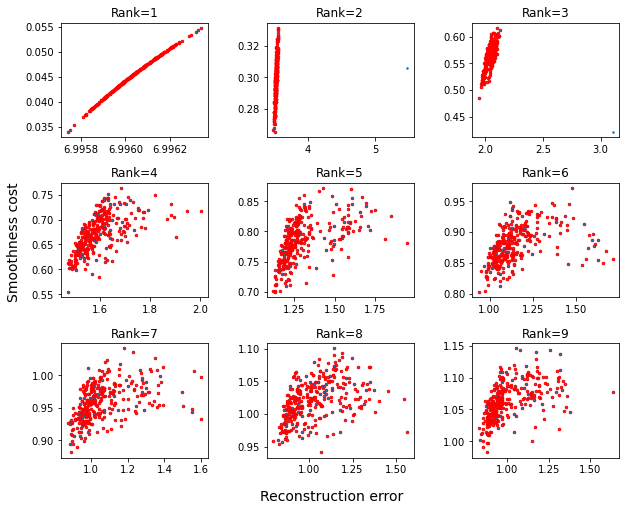

In [18]:
# Clustering without standardizing features
runs_wanted = []

fig, ax = plt.subplots(3,3,figsize=(10,8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for seq,rr in enumerate(rank_all):
    samples = np.vstack((mse_ori[seq,:], smc_ori[seq,:])).T
    if rr==2 or rr==3:
        kmeans = KMeans(n_clusters=2, random_state=0).fit(samples)
    else:
        kmeans = KMeans(n_clusters=1, random_state=0).fit(samples)
    which_is_good = kmeans.cluster_centers_[:,0].argmin(axis=0)
    runs_wanted.append(kmeans.labels_==which_is_good)
    axseq = np.unravel_index(seq,(3,3))
    ax[axseq].plot(samples[:,0], samples[:,1], '.', markersize=3)
    ax[axseq].plot(samples[kmeans.labels_==which_is_good, 0], 
                   samples[kmeans.labels_==which_is_good, 1], 
                   'r.', markerfacecolor='none', markersize=5)
    ax[axseq].set_title('Rank=%d'%rr)
fig.text(0.5, 0.05, 'Reconstruction error', fontsize=14, ha='center')
fig.text(0.05, 0.5, 'Smoothness cost', fontsize=14, va='center', rotation='vertical')
plt.show()

### Number of runs include for each rank:

In [19]:
num_files_per_rank = 8
num_runs_per_file = 40

In [20]:
[np.nonzero(x)[0].shape[0] for x in runs_wanted]

[320, 319, 319, 320, 320, 320, 320, 320, 320]

### Reshape to according to each pre-calc files

In [21]:
def reshape_runs_to_per_file(runs_all):
    runs_each_file = np.array(runs_all).reshape(-1).reshape(-1,num_runs_per_file)
    runs_each_file = [np.nonzero(runs_each_file[x,:])[0] for x in range(runs_each_file.shape[0])]
    return runs_each_file

In [22]:
runs_wanted_per_file = reshape_runs_to_per_file(runs_wanted)

In [23]:
# Sanity check: should have 72 files in total
len(runs_wanted_per_file)

72

## Compile H and W from selected runs

In [24]:
def gather_H_and_W(runs_wanted_per_file, container, fname, verbose=False):
    """
    Get H and W from the selected runs and put it into the container dictionary.
    """
    
    for seq_file,ff in enumerate(fname):
        with open(ff,'rb') as openfile:
            x = dill.load(openfile)

        # Start fresh H and W lists for new rank
        #  e.g., each rank has 8 files, so seq_f%8=0 means the beginning of a rank
        if seq_file % num_files_per_rank == 0:  
            H, W, fn_ln = [], [], []
            if verbose:
                print('file %0d: '%seq_file +'starting new rank')

        # Collect H from good runs in file ff
        if verbose:
            print('gather H and W in file: %s' % os.path.basename(ff))
        for seq_line,mm in enumerate(x):  # loop through all results in this file
            if seq_line in runs_wanted_per_file[seq_file]:
                H.append(mm['H'])
                W.append(mm['W'])
                fn_ln.append([seq_file, seq_line])
        if verbose:
            print('   total %d Hs and Ws gathered' % len(H))

        # Save H and W lists for this rank to master dict
        if (seq_file+1) % num_files_per_rank == 0:
            container['H'].append(H)
            container['W'].append(W)
            container['filenum_linenum'].append(fn_ln)
            if verbose:
                print('file %0d: '%seq_file +'ending this rank')
                print('---------------------------------------')

In [25]:
# Get MSE and SMC from the good runs
tsNMF_results_ori = defaultdict(list)
tsNMF_results_shf = defaultdict(list)

for rr in range(len(rank_all)):
    tsNMF_results_ori['recons_error'].append(mse_ori[rr, runs_wanted[rr]])
    tsNMF_results_ori['smoothness_reg_cost'].append(smc_ori[rr, runs_wanted[rr]])
    tsNMF_results_shf['recons_error'].append(mse_shf[rr, runs_wanted[rr]])
    tsNMF_results_shf['smoothness_reg_cost'].append(smc_shf[rr, runs_wanted[rr]])

In [26]:
gather_H_and_W(runs_wanted_per_file, tsNMF_results_ori, original_fname)
gather_H_and_W(runs_wanted_per_file, tsNMF_results_shf, shuffled_fname)

In [27]:
# Sanity check: should have 9 elements in this key
len(tsNMF_results_ori['H']), len(tsNMF_results_shf['H'])

(9, 9)

## MSE for the original and the shuffled runs

In [28]:
mse_ori_median = np.array([np.median(x) for x in tsNMF_results_ori['recons_error']])
mse_shf_median = np.array([np.median(x) for x in tsNMF_results_shf['recons_error']])

In [29]:
mse_ori_shifted = [x-mse_ori_median.max() for x in tsNMF_results_ori['recons_error']]
mse_shf_shifted = [x-mse_shf_median.max() for x in tsNMF_results_shf['recons_error']]

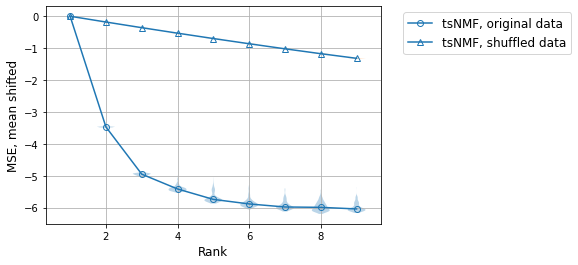

In [30]:
# ssNMF
plt.violinplot(mse_ori_shifted, rank_all, 
               showextrema=False, showmedians=False)
plt.violinplot(mse_shf_shifted, rank_all, 
               showextrema=False, showmedians=False)
ho = plt.plot(rank_all, mse_ori_median - mse_ori_median.max(), 
              'o-', markerfacecolor='none', color='C0')
hs = plt.plot(rank_all, mse_shf_median - mse_shf_median.max(), 
              '^-', markerfacecolor='none', color='C0')

plt.legend(['tsNMF, original data','tsNMF, shuffled data'], 
           fontsize=12, bbox_to_anchor=(1.05,1))
plt.xlabel('Rank', fontsize=12)
plt.ylabel('MSE, mean shifted', fontsize=12)
plt.grid()
plt.show()

plt.show()

## Cophenetic correlation coefficients

### Connectivity matrix

In [31]:
from operator import eq
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

In [32]:
def connectivity(HH):
    """
    Compute the connectivity matrix for the samples based on their mixture coefficients.
    """
    
    idx = np.argmax(HH, axis=0)
    mat1 = np.tile(idx, (HH.shape[1], 1))
    conn = eq(np.mat(mat1), np.mat(mat1.T))
    return np.mat(conn, dtype='d')

In [33]:
conn_mtx = []
for seq in range(len(tsNMF_results_ori['H'])):  # loop through all rank
    cm = []
    for h,w in zip(tsNMF_results_ori['H'][seq], tsNMF_results_ori['W'][seq]):
        cm.append(connectivity((h.T*np.linalg.norm(w, axis=0)).T))
    conn_mtx.append(cm)

In [34]:
print('conn_mtx has %d elements, each corresponding to results from a particular rank 1-9.' % len(conn_mtx))

conn_mtx has 9 elements, each corresponding to results from a particular rank 1-9.


In [35]:
# Sanity check: number of runs included=319 for rank=3, dimension of the connectivity matrix = 62x62
np.array(conn_mtx[2]).shape

(319, 62, 62)

### Concensus matrix

The consensus matrix here is computed with weightings as proposed by [Frigyesi and Hoglund 2008](https://journals.sagepub.com/doi/10.4137/CIN.S606). We can visualize the consensus matrix by "optimally" ordering the days from agglomerative clustering results.

In [36]:
def calc_weights(e_vec):
    """
    Calculate weights for computing weighted consensus matrix.
    
    Parameters
    ----------
    e_vec
        mean squared error of all runs of all ranks
    """
    w = []
    for r_idx in range(len(rank_all)):
        RE_max = e_vec[r_idx].max()
        RE_min = e_vec[r_idx].min()
        w.append((RE_max-e_vec[r_idx])/(RE_max-RE_min))
    return w

In [37]:
def consensus(conn_mtx, wgt=None, plot_opt=True):
    """
    Compute the consensus matrix.
    
    Parameters
    ----------
    conn_mtx : [run x num_days x num_days]
        connectivity matrix
    wgt : [run]
        weight for each connectivity matrix
        default: None, when the computation is not weighted
    """
    if wgt is not None:
        if conn_mtx.shape[0] != len(wgt):  # verify dimension match
            raise ValueError('dimension mismatch between consensus matrix and weights!')
        else:
            conn_mtx_wgt = conn_mtx * np.expand_dims(wgt, axis=(1,2))
            C = conn_mtx_wgt.sum(axis=0)/wgt.sum()
    else:
        C = conn_mtx.mean(axis=0)
    
    return C

In [38]:
def plot_consensus_mtx(C):
    """
    Plot the consensus matrix in the original order and clustered order.
    
    Parameters
    ----------
    C
        consensus matrix
    """
              
    # Cluster and order consensus matrix
    CZ = hierarchy.linkage(C)
    CZ_optimal = hierarchy.optimal_leaf_ordering(CZ,C)
    leaf_idx = hierarchy.leaves_list(CZ)
    leaf_idx_optimal = hierarchy.leaves_list(CZ_optimal)
    
    # Plot
    fig,ax = plt.subplots(1,3,figsize=(12,3),sharey=True,sharex=True)
    
    # original sequence
    im = ax[0].imshow(C, interpolation='none')
    ax[0].set_title('Consensus mtx', fontsize=12)
    plt.colorbar(im,ax=ax[0])
    
    # ordered based on clustering
    im = ax[1].imshow(C[leaf_idx,:][:,leaf_idx], interpolation='none')
    ax[1].set_title('Consensus ordered', fontsize=12)
    plt.colorbar(im,ax=ax[1])
    
    # optimal ordering after clustering
    im = ax[2].imshow(C[leaf_idx_optimal,:][:,leaf_idx_optimal], interpolation='none')
    ax[2].set_title('Consensus ordered optimal', fontsize=12)
    plt.colorbar(im,ax=ax[2])
    
    plt.show()


In [39]:
weighting = calc_weights(tsNMF_results_ori['recons_error'])

rank=1


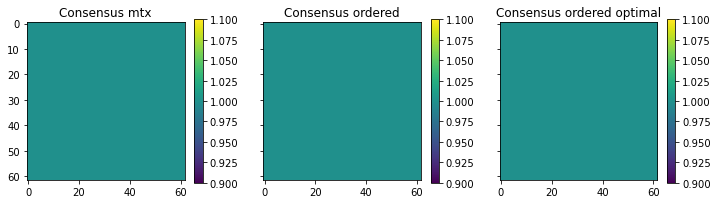

rank=2


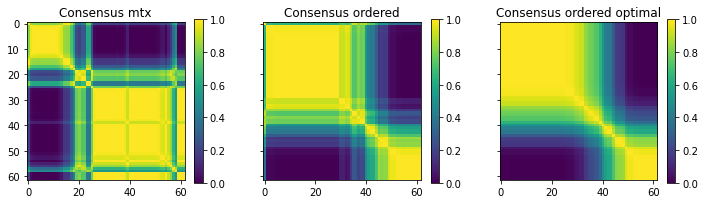

rank=3


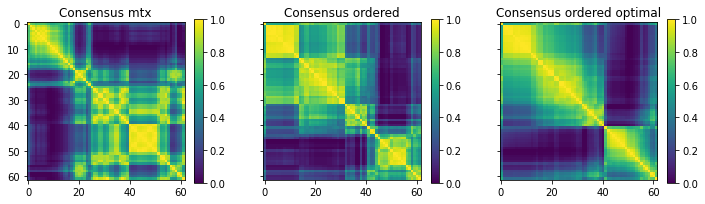

rank=4


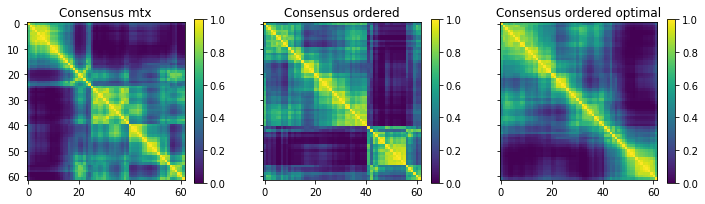

rank=5


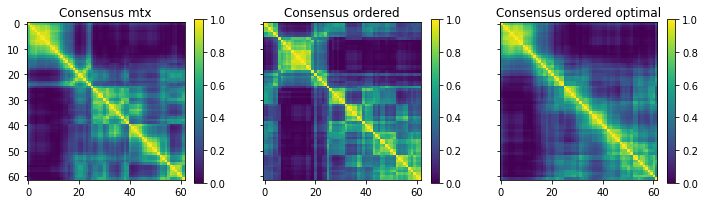

rank=6


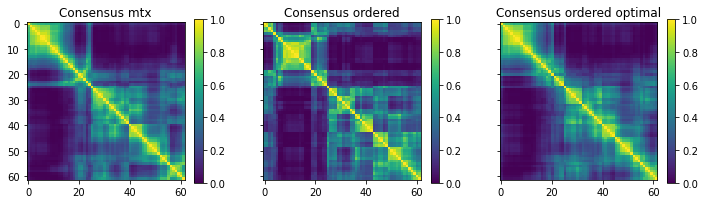

rank=7


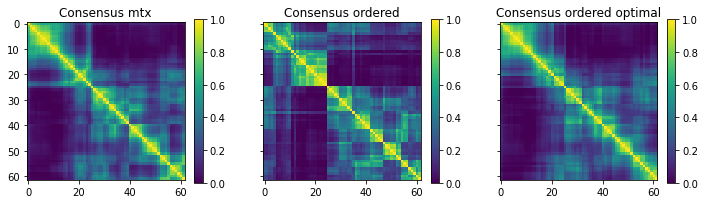

rank=8


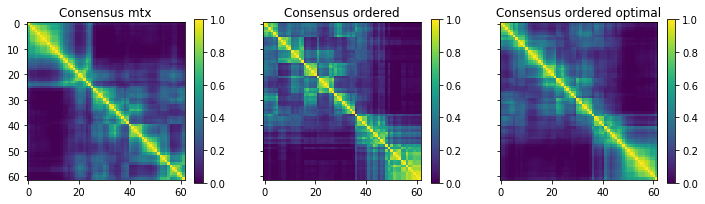

rank=9


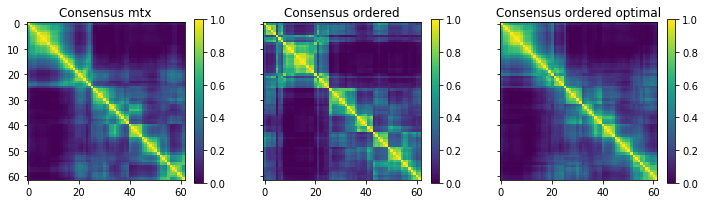

In [40]:
# Consensus matrix including all wanted runs
for rr in rank_all:
    print('rank=%d' % rr)
    r_idx = np.argwhere(rr==rank_all)[0,0].squeeze()
    c_tmp_wgt = consensus(np.array(conn_mtx[r_idx]), 
                          weighting[r_idx])
    plot_consensus_mtx(c_tmp_wgt)

### Cophenetic correlation coefficients

In [41]:
def coph_cor(C, verbose=False):
    """
    Compute cophenetic correlation coefficient of consensus matrix, 
    generally obtained from multiple NMF runs. 
    
    This implementation is from nimfa.
    
    Parameters
    ----------
    C
        consensus matrix
    verbose
        whether to print messages if np.clip is needed to correct 
        for numerical instability in linkage calculation.
    """

    # upper diagonal elements of consensus
    avec = np.array([C[i, j] for i in range(C.shape[0] - 1)
                    for j in range(i + 1, C.shape[1])])
    
    # consensus entries are similarities, conversion to distances
    Y = 1 - avec
    Z = hierarchy.linkage(Y, method='average')
    
    # check if any linkage is negative
    if np.sum(Z[:,2]<0) != 0:
        if verbose:
            print('Some linkages are negative!')
            print(Z[Z[:,2]<0, 2])          # but hopefully they are close to 0
        np.clip(Z[:,2], 0, 1, Z[:,2])  # clip the values to be between 0 and 1
    
    # cophenetic correlation coefficient of a hierarchical clustering
    # defined by the linkage matrix Z and matrix Y from which Z was
    # generated
    return (hierarchy.cophenet(Z, Y)[0], hierarchy.cophenet(Z, Y)[1])

In [42]:
# Get cophenetic correlation coefficients across rank
cc = np.zeros(len(rank_all))
for rr in rank_all:
    r_idx = np.argwhere(rr==rank_all)[0,0].squeeze()  # index of the rank

    if rr == 1:
        cc[r_idx] = 1
    else:
        c_tmp = consensus(np.array(conn_mtx[r_idx]), weighting[r_idx])
        cc[r_idx] = coph_cor(c_tmp)[0]

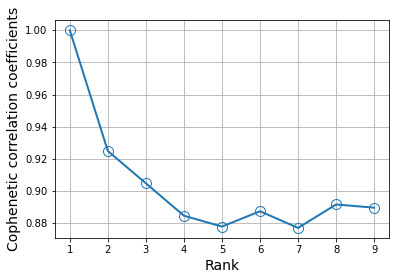

In [43]:
plt.plot(rank_all, cc, 'o-', markerfacecolor='none', markersize=10, lw=2)
plt.xlabel('Rank', fontsize=14)
plt.ylabel('Cophenetic correlation coefficients', fontsize=14)
plt.grid()
plt.show()

## Fig. S2. Rank selection metrics

In [44]:
panel_ls = 11
axis_ls = 11
tick_ls = 9
other_ls = 11

In [45]:
import matplotlib
matplotlib.rcParams['text.usetex'] = False

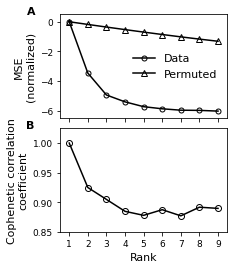

In [46]:
fig,ax = plt.subplots(2,1,figsize=(3,4), sharex=True)
plt.subplots_adjust(hspace=0.1)


# MSE vs rank
ho = ax[0].plot(rank_all, mse_ori_median - mse_ori_median.max(), 
              '.-', markerfacecolor='none', color='k', markersize=10)
hs = ax[0].plot(rank_all, mse_shf_median - mse_shf_median.max(), 
              '^-', markerfacecolor='none', color='k')
ax[0].set_xticks(rank_all)
ax[0].tick_params(labelsize=tick_ls)
ax[0].legend(['Data','Permuted'], fontsize=other_ls, loc='best', edgecolor='none')
ax[0].set_ylabel('MSE\n(normalized)', fontsize=axis_ls)
ax[0].set_xlim(0.5,9.5)
ax[0].set_ylim(-6.5,0.5)

# Cophenetic correlation coefficients
ax[1].plot(rank_all, cc, 'ko-', markerfacecolor='none')
ax[1].set_xticks(rank_all)
ax[1].tick_params(labelsize=tick_ls)
ax[1].set_xlim(0.5,9.5)
ax[1].set_ylim(0.85, 1.025)
ax[1].set_ylabel('Cophenetic correlation\ncoefficient', fontsize=axis_ls)
ax[1].set_xlabel('Rank', fontsize=axis_ls)

# Add panel labels
fig.text(x=-0.2,y=1,s='A', transform=ax[0].transAxes,
         fontsize=panel_ls, fontweight='bold')
fig.text(x=-0.2,y=1,s='B', transform=ax[1].transAxes,
         fontsize=panel_ls, fontweight='bold')

# Save figure
fig.savefig(os.path.join('../figs/fig_si_rank_sel.png'),
            dpi=300, bbox_inches = 'tight', pad_inches = 0.05)

plt.show()